#Recurrent Neural Networks from scratch
In this lab you will implement a basic cell from a Recurrent Neural Network (RNN). The RNN will try to reconstruct a sinusoidal wave. 


In [1]:
import torch
import math
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

torch.manual_seed(8989)

##RNN basic cell

We will implement a basic RNN cell in pytorch. Remember the main equations for a basic RNN:

$
\begin{eqnarray*}
h^{<t>} &=& \mathrm{relU}(\mathbf{W}_{h}\left(\begin{array}{c} h^{<t-1>} \\x^{<t>} \end{array}\right) + b_{h})\\
y^{<t>} &=& \mathbf{W}_{y}h^{<t>} + b_{y}
\end{eqnarray*}$

Where:
- $x^{<t>}$: input vector at time $t$ 
- $h^{<t>}$: new state
- $h^{<t-1>}$: previous state
- $\mathbf{W}_h = \left( \mathbf{W}_{hh}; \mathbf{W}_{hx}\right), \mathbf{W}_y, b_h, b_y$ are the parameters

Remember that to implement a layer, you have to create a new class that inherits from `nn.Module`. There are two functions you have to think about:

`__init__` function:


*   Look carefully at the arguments given in its signature.
*   Create tensors for the weights of the layer with the appropriate shape. The shape of our weights is determined by the arguments `input_size`, `hidden_size` and `output_size`.
*   Create the bias tensors with the appropriate shapes.
*   **Remember to wrap the tensors in `torch.nn.Parameter` so they become differentiable parameters**

`forward` function:


*   Given a new input $x^{<t>}$ and the previous hidden vector $h^{<t-1>}$ calculate $y^{<t>}$ and $h^{<t>}$ (return the output as a tuple)

**EXERCISE:** Implement the layer `RNNCell` following the instructions above.

In [12]:
class RNNCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        self.w_h = None
        self.b_h = None
        self.w_y = None
        self.b_y = None

        ### WRITE YOUR CODE HERE (~8 lines) ###
        self.w_h = torch.zeros(hidden_size, (hidden_size+input_size))
        
        self.b_h = torch.zeros((hidden_size,1))

        self.w_y = torch.zeros((output_size, hidden_size))
        
        self.b_y = torch.zeros((output_size,1))

        self.w_h = torch.nn.Parameter(self.w_h)
        self.b_h = torch.nn.Parameter(self.b_h)
        self.w_y = torch.nn.Parameter(self.w_y)
        self.b_y = torch.nn.Parameter(self.b_y)
        ########################

        # init parameters
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weigth in self.parameters():
            with torch.no_grad():
                weigth.uniform_(-stdv, stdv)

    def forward(self, x, h):
        '''Perform a one step forward pass.

        Input:
        - x: input tensor at time t (input_size)
        - h: hidden state at time t-1  (hidden_size). Set all zeros for first hidden state.

        Output: a tuple with two values
        - yhat: y output       (output_size)
        - h: next hidden state (hidden_size)
        '''
        yhat = None
        next_h = None
        
        ### WRITE YOUR CODE HERE ### (~4 lines)
        next_h = torch.nn.functional.relu(torch.matmul(self.w_h , torch.cat((h, x))) + self.b_h)
        
        yhat = torch.matmul(self.w_y , next_h) + self.b_y
        ########################
        return yhat, next_h



## Data preparation

We will create the training data. Each example is composed by a pair $(x^{(i)}, y^{(i)})$ where:

- $x^{(i)}$ is a vector corresponding to the wave values $(i,\ldots,i+\mathrm{seq\_len})$ 
- $y^{(i)}$ is a vector corresponding to the wave values $(i+1,\ldots,i+\mathrm{seq\_len}+1)$



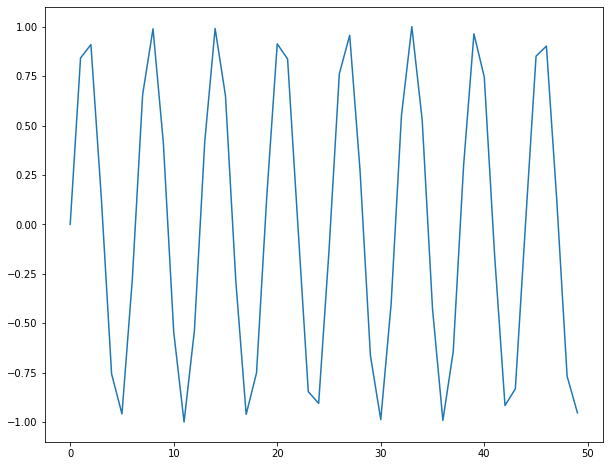

In [8]:
sin_wave = [math.sin(x) for x in torch.arange(200)]
seq_len = 50
num_records = len(sin_wave)

plt.plot(sin_wave[:50])
plt.show()

##### prepare the training data

X = []
Y = []
for i in range(num_records - seq_len):
    X.append(torch.tensor([0] + sin_wave[i:i+seq_len - 1]))
    Y.append(torch.tensor(sin_wave[i:i+seq_len]))
X = torch.stack(X)
Y = torch.stack(Y)


## Train the RNN

Now we will train the RNN with the training data. 

The training procedure will be the following:

- for each training instance $(x^{(i)}, y^{(i)})$ do:
 - init loss to zero
 - set $h$ to zero
 - for j in $1\ldots$ `seq_len`
   - create a one-hot vector $x$ with all zeros except the $j$th component, which is $x^{(i)}_j$
   - call RNN with $x$ and $h$.
   - increase loss using the `criterion`function, comparing the output of RNN with $y^{(i)}_j$

**EXERCISE**: complete the code within the training loop. **You should obtain a training loss of circa 1.73**

In [15]:
learning_rate = 0.001
nepoch = 50
T = seq_len                   # length of sequence
hidden_size = 100
output_size = 1
rnn = RNNCell(seq_len, hidden_size, output_size)
criterion = torch.nn.MSELoss() # criterion is mean square loss (sqrt(y_hat^2 - y))
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate) # Stochastic gradient descend
losses = []
for epoch in range(nepoch):
    for x,y in zip(X, Y):
        ### WRITE YOUR CODE HERE ###
        loss = 0
        h = torch.zeros(hidden_size,1)
        for j in range(1, seq_len):
          vector_x = torch.zeros(seq_len,1)
          vector_x[j] = x[j]
          yhat, next_h = rnn(vector_x,h)
          loss = criterion(yhat, y[j])
          h = next_h
        ########################
        losses.append(loss.item())
        optimizer.zero_grad() # init gradients
        loss.backward()       # compute gradients
        optimizer.step()      # update step
    print(loss.item())
print(f'Train loss {sum(losses)/len(losses)}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.019338417798280716
0.020442524924874306
0.022555239498615265
0.025391651317477226
0.028064902871847153
0.030452337116003036
0.03266163170337677
0.03407284989953041
0.034840963780879974
0.034726906567811966
0.03280915319919586
0.02932097017765045
0.024316975846886635
0.01850443333387375
0.012754705734550953
0.007859035395085812
0.004312155302613974
0.002086648950353265
0.0008620609878562391
0.0002790433063637465
5.3201121772872284e-05
5.819629222969525e-07
1.3855148608854506e-05
4.4225682358955964e-05
7.252045907080173e-05
9.33905757847242e-05
0.00010685685992939398
0.000114134767500218
0.00011799001367762685
0.0001190470575238578
0.00011845046537928283
0.000116529714432545
0.00011402240488678217
0.00011133346561109647
0.00010845241922652349
0.0001055307438946329
0.0001026251120492816
9.966213838197291e-05
9.665053948992863e-05
9.39917445066385e-05
9.11960523808375e-05
8.86613197508268e-05
8.628157956991345e-05
8.387088018935174e-05
8.154061652021483e-05
7.931456639198586e-05
7.680845

## Test the model

We will create a slightly shifted sinusoidal wave and complete it with the results of the trained RNN.

The testing procedure is almost the same to the training procedure, except:

- we iterate through the test dataset
- we only calculate the loss for the last time step
- we do not backpropagate the losses

In summary, write the same code you wrote for training, but **discard all management of the `loss` variable**.

**EXERCISE**: complete the code within the test loop. **You should obtain a test loss of circa $2.08e^{-4}$**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 4.695088697855473e-05


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


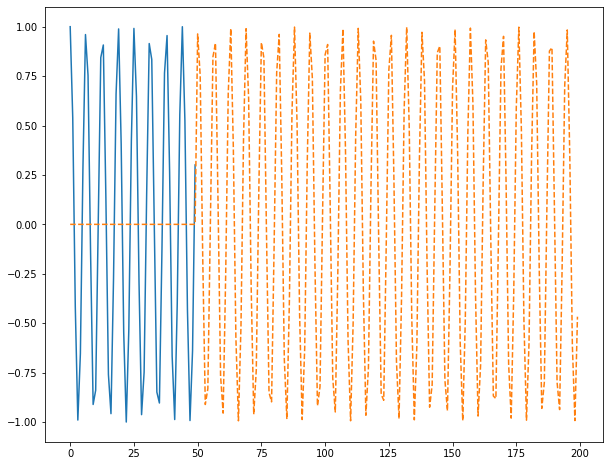

In [17]:
sin_wave_test = [math.sin(math.pi * 0.5 + x) for x in torch.arange(200)]
X_test = []
Y_test = []
for i in range(num_records - seq_len):
    X_test.append(torch.tensor(sin_wave_test[i:i+seq_len]))
    Y_test.append(torch.tensor(sin_wave_test[i+seq_len]))
X_test = torch.stack(X_test)
Y_test = torch.stack(Y_test)

plt.plot(sin_wave_test[:seq_len])

generated_wave = [0] * seq_len
test_losses = []
with torch.no_grad():
    for x,y in zip(X_test, Y_test):
        ### WRITE YOUR CODE HERE (~5 lines) ###
        h = torch.zeros(hidden_size,1)
        for j in range(1, seq_len):
          vector_x = torch.zeros(seq_len,1)
          vector_x[j] = x[j]
          yhat, next_h = rnn(vector_x,h)
          h = next_h
        ########################
        # last yhat predicts y
        generated_wave.append(yhat[0])
        # loss is calculated only for the last time step
        loss = criterion(yhat[0], y)
        test_losses.append(loss.item())
print(f'Test loss: {sum(test_losses)/len(test_losses)}')
plt.plot(generated_wave, '--')
plt.show()
